In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import  Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)

2024-02-18 07:40:52.961326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 07:40:52.961456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 07:40:53.076805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version:  2.15.0


Exploring Dataset

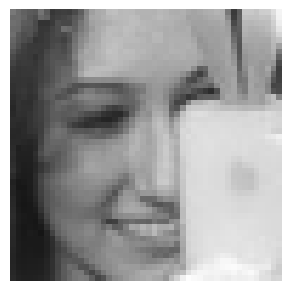

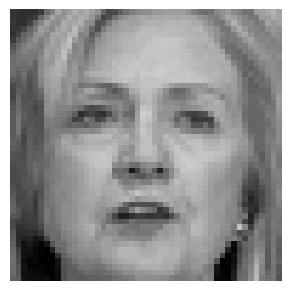

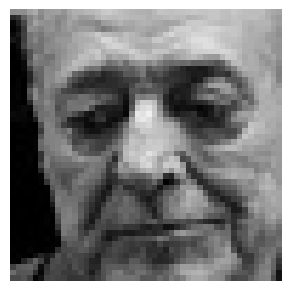

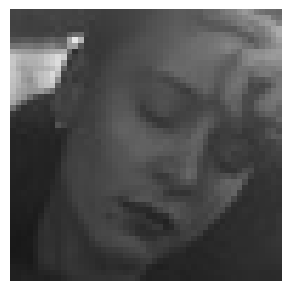

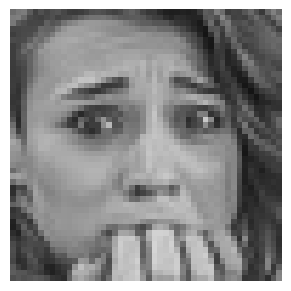

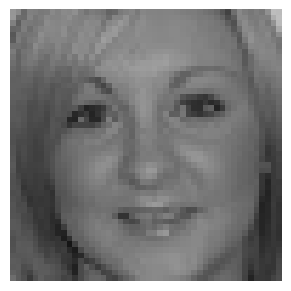

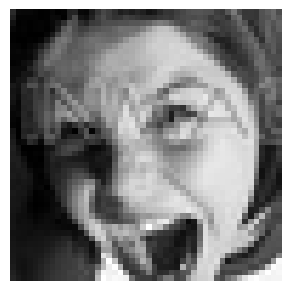

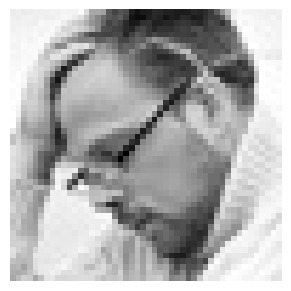

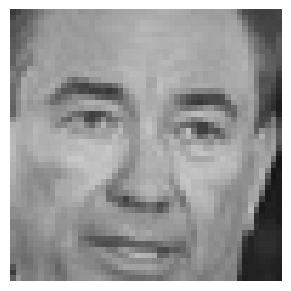

In [2]:
images = glob("/kaggle/input/fer2013/train/**/**")

for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [3]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory('/kaggle/input/fer2013/train/',
                                                    target_size = (img_size, img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory('/kaggle/input/fer2013/test/',
                                                    target_size = (img_size, img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)  # Changed to 'elu'
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)  # Changed to 'elu'
    x = Dropout(0.25)(x)
    return x

In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 64, (3,3))
    conv_2 = Convolution(conv_1, 128, (5,5))  # Now takes conv_1 as input
    conv_3 = Convolution(conv_2, 256, (3,3))  # Added layer, adjusted filters
    conv_4 = Convolution(conv_3, 512, (3,3))  # Added layer, Now takes conv_3 as input
    conv_5 = Convolution(conv_4, 512, (3,3))  # Added layer, Now takes conv_4 as input

    flatten = Flatten()(conv_5)  # Now flattening conv_5

    dense_1 = Dense_f(flatten, 256)
    dense_2 = Dense_f(dense_1, 512)  # Now correctly connected

    output = Dense(7, activation='softmax')(dense_2)  # Connects to dense_2
    model = Model(inputs=[inputs], outputs=[output])
    
    opt = Adam(lr=0.0005)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [7]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

Initializing the Model

In [8]:
epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weight.h5", monitor= 'val_accuracy', save_weights_only= True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor= 'val_loss', factor = 0.1, patience = 2, min_lr = 0.00001)
callbacks = [checkpoint, reduce_lr]

# Training the Model

The next cell takes time to complete 

In [9]:
history = model.fit(
    x = train_generator,
    steps_per_epoch  = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks
)

Epoch 1/30


2024-02-18 07:41:34.801805: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708242098.343172     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 [==============================] - ETA: 0s - loss: 1.8053 - accuracy: 0.3143
Epoch 1: saving model to model_weight.h5
448/448 [==============================] - 172s 365ms/step - loss: 1.8053 - accuracy: 0.3143 - val_loss: 1.5903 - val_accuracy: 0.4143 - lr: 0.0010
Epoch 2/30
448/448 [==============================] - ETA: 0s - loss: 1.4536 - accuracy: 0.4452
Epoch 2: saving model to model_weight.h5
448/448 [==============================] - 39s 87ms/step - loss: 1.4536 - accuracy: 0.4452 - val_loss: 1.5814 - val_accuracy: 0.4311 - lr: 0.0010
Epoch 3/30
448/448 [==============================] - ETA: 0s - loss: 1.3180 - accuracy: 0.4981
Epoch 3: saving model to model_weight.h5
448/448 [==============================] - 43s 96ms/step - loss: 1.3180 - accuracy: 0.4981 - val_loss: 1.3267 - val_accuracy: 0.5086 - lr: 0.0010
Epoch 4/30
448/448 [==============================] - ETA: 0s - loss: 1.2429 - accuracy: 0.5276
Epoch 4: saving model to model_weight.h5
448/448 [==============

In [11]:
model.evaluate(validation_generator)

113/113 [==============================] - 7s 64ms/step - loss: 0.9949 - accuracy: 0.6357


[0.9948543906211853, 0.6356924176216125]

Ploting Loss

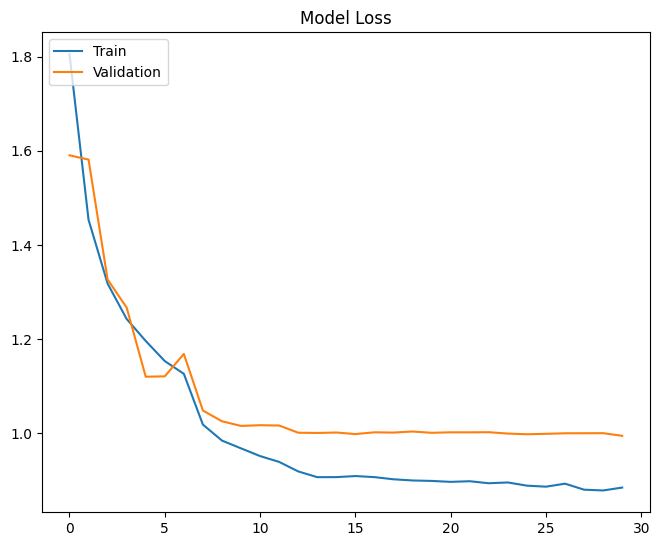

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel = ('Epoch')
plt.ylabel = ('Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

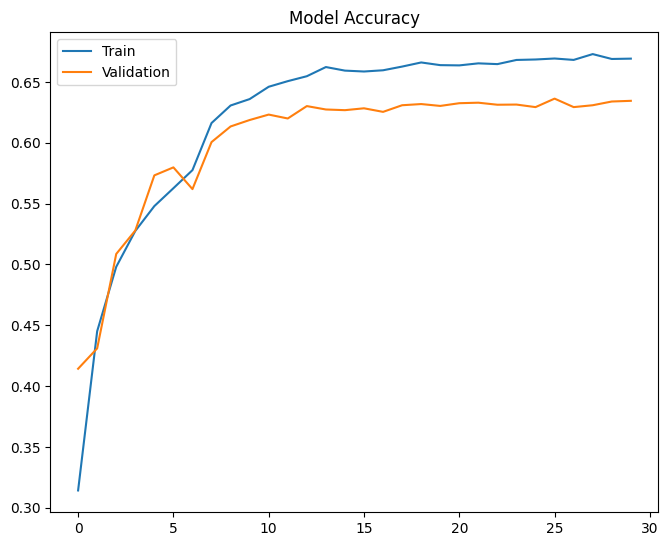

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel = ('Epoch')
plt.ylabel = ('Accuracy')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

In [14]:
model_json = model.to_json()
with open('model_a.json', 'w') as json_file:
    json_file.write(model_json)